# **PREPROCESSING**
<hr>

## **Import Libraries**

In [173]:
# Import Libraries
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import missingno

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## **Import Data**

In [174]:
# Import Data
df=pd.read_csv('./archive/DC_Properties.csv')
df_model = df.copy()

## **Data Duplicate**

In [ ]:
df_model.duplicated().sum()

: 

: 

Tidak terdapat data duplicate.

## **Missing Value and Outlier**

<AxesSubplot:>

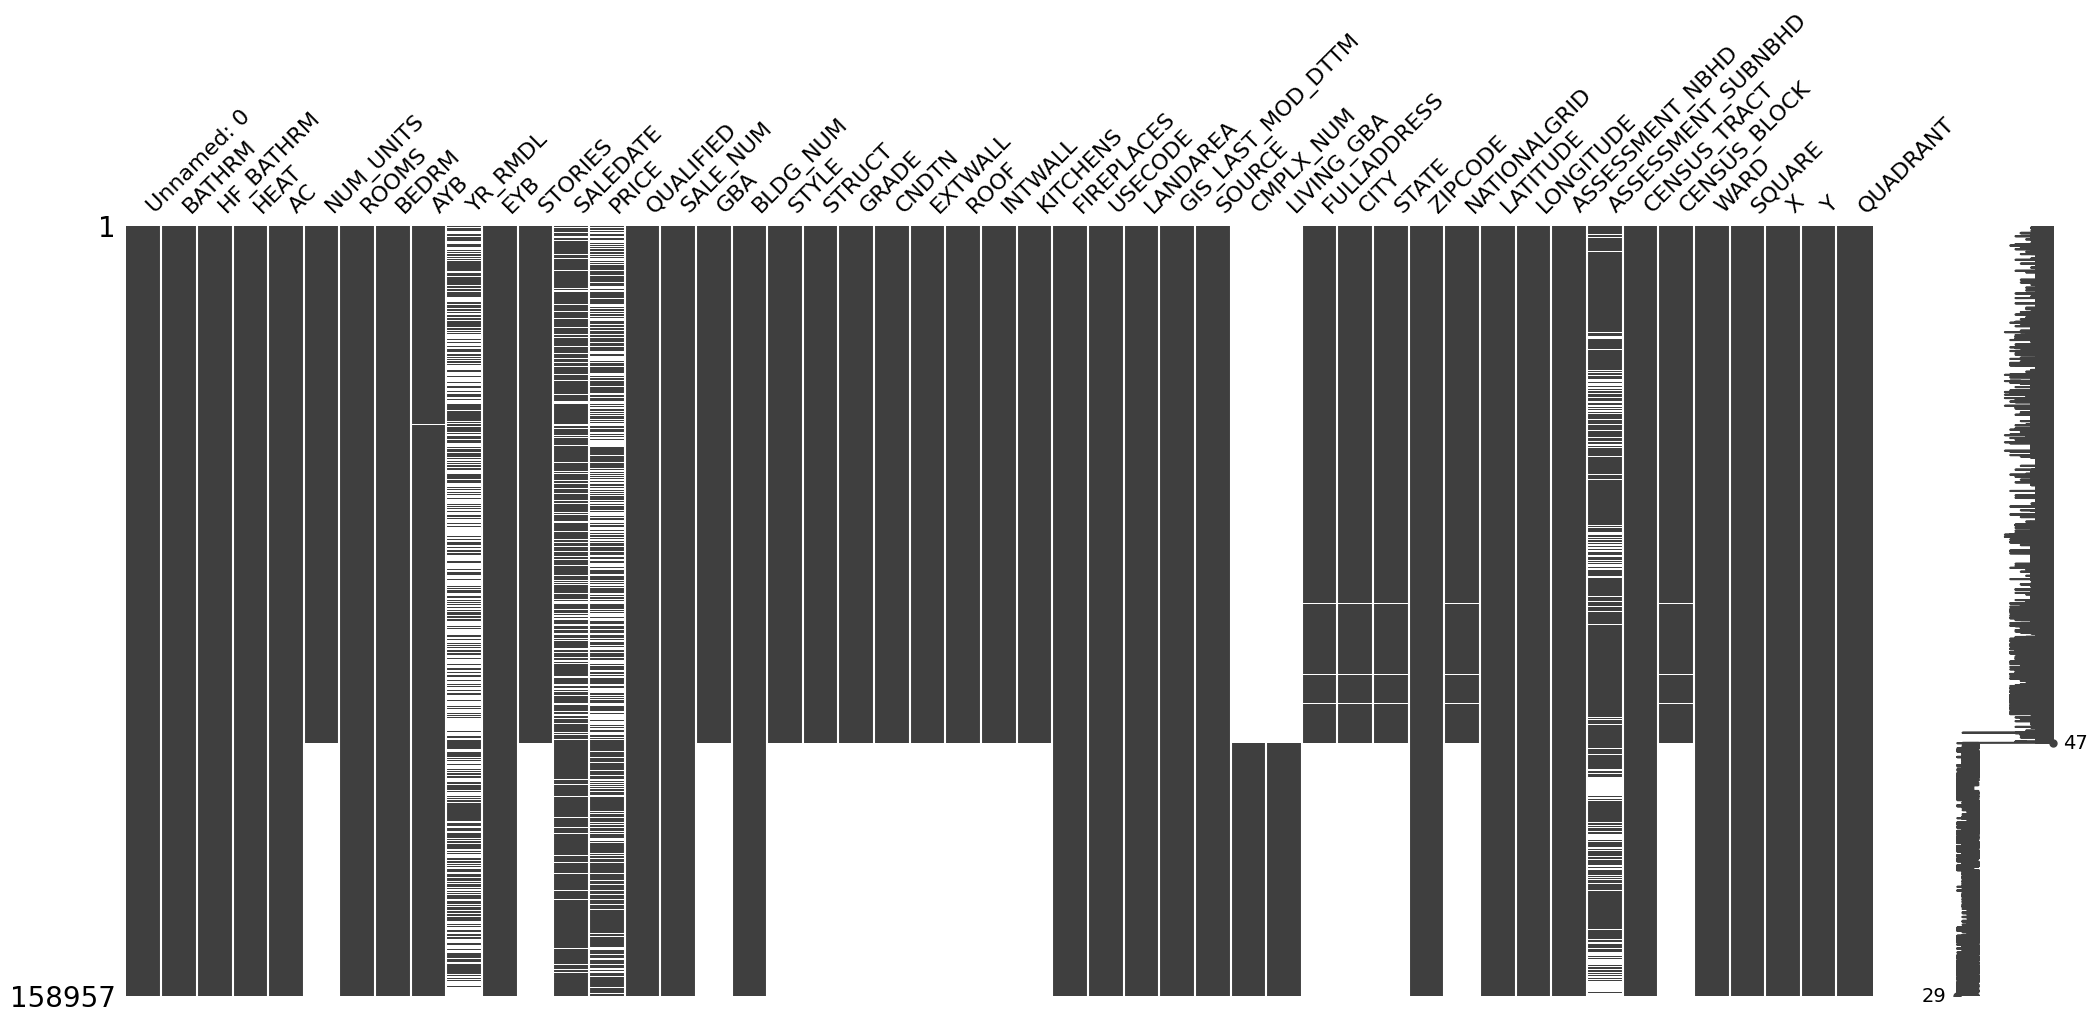

In [ ]:
missingno.matrix(df)

In [ ]:
# Cek nilai missing value
df_model.isnull().sum()

Unnamed: 0                 0
BATHRM                     0
HF_BATHRM                  0
HEAT                       0
AC                         0
NUM_UNITS              52261
ROOMS                      0
BEDRM                      0
AYB                      271
YR_RMDL                78029
EYB                        0
STORIES                52305
SALEDATE               26770
PRICE                  60741
QUALIFIED                  0
SALE_NUM                   0
GBA                    52261
BLDG_NUM                   0
STYLE                  52261
STRUCT                 52261
GRADE                  52261
CNDTN                  52261
EXTWALL                52261
ROOF                   52261
INTWALL                52261
KITCHENS               52262
FIREPLACES                 0
USECODE                    0
LANDAREA                   0
GIS_LAST_MOD_DTTM          0
SOURCE                     0
CMPLX_NUM             106696
LIVING_GBA            106696
FULLADDRESS            52917
CITY          

Didefinisikan persamaan untuk mendeskripsikan batas outlier pada setiap fitur sebagai berikut.

In [ ]:
# Cek Outliers
def fn_an(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    limit_bawah = q1 - limit
    limit_atas = q3 + limit
    return iqr, limit_bawah, limit_atas


def pr_an(data):
    x,y,z = fn_an(data)
    print(f'IQR: {x}')
    print(f'limit_bawah: {y}')
    print(f'limit_atas: {z}')   

In [ ]:
loss_col = []
loss_dat = []

### Target: `PRICE`

Fitur `Price` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'PRICE'
df_model[feature].describe()

count    9.821600e+04
mean     9.313516e+05
std      7.061325e+06
min      1.000000e+00
25%      2.400000e+05
50%      3.999990e+05
75%      6.520000e+05
max      1.374275e+08
Name: PRICE, dtype: float64

In [ ]:
lossnum = df_model[df_model[feature].isnull()].shape[0]
lossper = df_model[df_model[feature].isnull()].shape[0]/df.shape[0]*100
loss_col.append(feature+"_null")
loss_dat.append(lossper)
print('Jumlah fitur {} dengan data hilang adalah '.format(feature), lossnum)
print('Persentase fitur {} dengan data hilang adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah fitur PRICE dengan data hilang adalah  60741
Persentase fitur PRICE dengan data hilang adalah  38.21%


In [ ]:
df_model.drop(df_model[df_model[feature].isnull()].index, inplace=True)

Sebanyak 60741 atau 38.21% data dihapus dari dataset dikarenakan tidak reliable untuk digunakan pada pemodelan.

Berikut merupakan plot distribusi pada fitur `PRICE`. 

Text(0.5, 1.0, 'PRICE Distribution Plot')

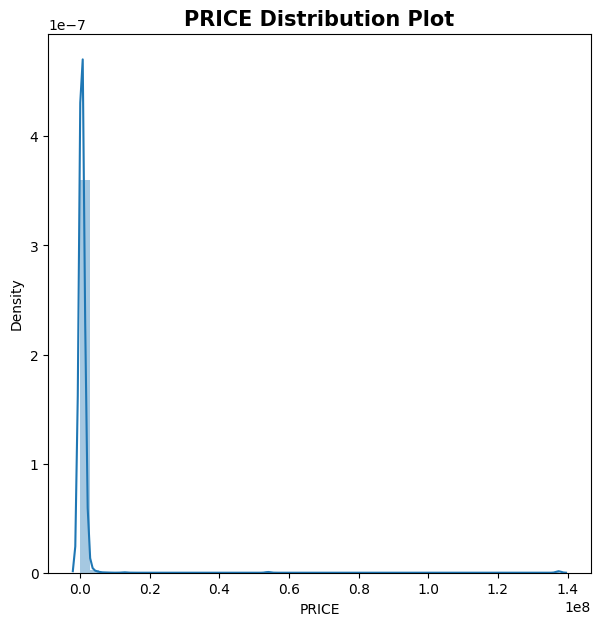

In [ ]:
plt.figure(figsize=(7, 7))
sns.distplot(df_model[feature])
plt.title('{} Distribution Plot'.format(feature), size=15, weight='bold')

Anomali pada distribusi fitur `Price` dapat dianalisis sebagai berikut.

In [ ]:
iqr, bot_val, up_val = fn_an(df_model[feature])
pr_an(df_model[feature])

IQR: 412000.0
limit_bawah: -378000.0
limit_atas: 1270000.0


In [ ]:
lossnum = df_model[df_model[feature] > up_val].count()[feature]
lossper = df_model[df_model[feature] > up_val].count()[feature]/df.shape[0]*100
loss_col.append(feature + "_out")
loss_dat.append(lossper)
print('Jumlah outlier pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah outlier pada fitur PRICE adalah  5655
Persentase outlier pada fitur PRICE adalah  3.56%


Berdasarkan plot distribusi, pada harga penjualan properti terdapat *right-skewed distribution* atau terdapat skewness positif pada fitur `PRICE`. <br>
Terdapat 5.76% outlier pada fitur `PRICE` dimana harga berada diatas $ 1.270.000. Persentase ini cukup kecil sehingga dapat dihilangkan dari pemodelan sehingga nilai skewness dapat berkurang. Namun, hal ini dapat menjadi limitasi dari model yang dibangun.

In [ ]:
df_model = df_model[(df_model[feature] <= up_val)]

Text(0.5, 0, 'Range Selected PRICE')

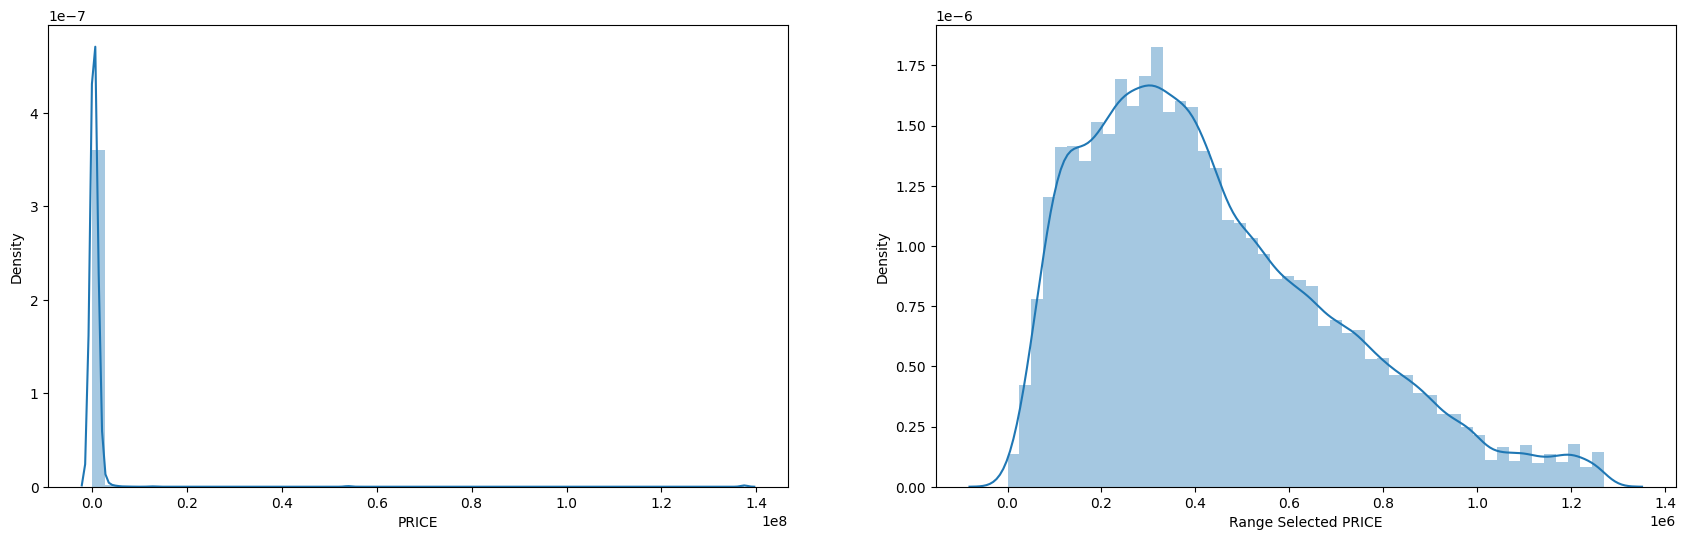

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df[feature], ax=axes[0])
sns.distplot(df_model[feature], ax=axes[1])
axes[0].set_xlabel(feature)
axes[1].set_xlabel('Range Selected {}'.format(feature))

Dari hasil data cleaning yang dilakukan pada feature `Price`, didapatkan rentang data harga penjualan rumah diantara $1 - $1.270.000

### Feature: `Unnamed: 0`

Feature 'Unnamed: 0' tidak dibutuhkan karena hanya berisi nomor tiap data sehingga dapat dihapus.

In [ ]:
df_model.drop(columns=['Unnamed: 0'], inplace= True)

### Feature: `YR_RMDL`

Pengertian dari feature `YR_RMDL` merupakan tahun dari properti direnovasi ulang, tetapi tidak semua properti pernah mengalami renovasi. Maka dari itu, feature ini akan diubah menjadi data kategorikal yang terdiri dari `1` untuk properti yang pernah direnovasi dan `0` untuk properti yang belum pernah direnovasi.

In [ ]:
df_model['YR_RMDL'] = df_model['YR_RMDL'].apply(lambda x: '0' if np.isfinite(x) == False  else '1')

Fitur `YR_RMDL` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
df_model['YR_RMDL'].describe(include=object)

count     71915
unique        2
top           1
freq      42768
Name: YR_RMDL, dtype: object

### FEATURE: `AYB`

Fitur `AYB` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'AYB'
df_model[feature].describe()

count    71844.000000
mean      1944.830995
std         36.287327
min       1765.000000
25%       1917.000000
50%       1938.000000
75%       1966.000000
max       2018.000000
Name: AYB, dtype: float64

Terdapat beberapa data yang hilang, sehingga nilai feature `AYB` yang hilang akan disamakan dengan feature `EYB`.

In [ ]:
def change_ayb(x):
    if np.isfinite(x['AYB']) == False:
        return x['EYB']
    else:
        return x['AYB']
    
df_model['AYB'] = df_model[['AYB', 'EYB']].apply(change_ayb, axis = 1)

Dikarenakan terdapat nilai `AYB` lebih tinggi daripada `EYB`, maka row yang mengandung nilai ini akan dibuang.

In [ ]:
lossnum = df_model[df_model['AYB'] > df_model['EYB']].count()[feature]
lossper = df_model[df_model['AYB'] > df_model['EYB']].count()[feature]/df.count()[feature]*100
loss_col.append(feature+"_big")
loss_dat.append(lossper)

print('Jumlah nilai 0 pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah nilai 0 pada fitur AYB adalah  689
Persentase outlier pada fitur AYB adalah  0.43%


In [ ]:
df_model = df_model.drop(df_model[df_model['AYB'] > df_model['EYB']].index, axis=0)

### Feature: `SALEDATE`

Fitur `SALEDATE` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'SALEDATE'
df_model[feature].describe()

count                   71226
unique                   6379
top       2018-05-29 00:00:00
freq                       72
Name: SALEDATE, dtype: object

Dikarenakan tipe data berupa tanggal, maka data akan disederhanakan menjadi tahun dan bulan penjualan.

In [ ]:
df_date = pd.DataFrame(data = df_model["SALEDATE"].astype("datetime64"))
df_model["SALEYEAR"] = df_date["SALEDATE"].dt.year
df["SALEYEAR"] = df_date["SALEDATE"].dt.year
df_model["SALEMONTH"] = df_date["SALEDATE"].dt.month
df_model.drop('SALEDATE',axis=1,inplace=True)

Berikut merupakan plot distribusi pada fitur `SALEYEAR`. 

Text(0.5, 1.0, 'SALEYEAR Distribution Plot')

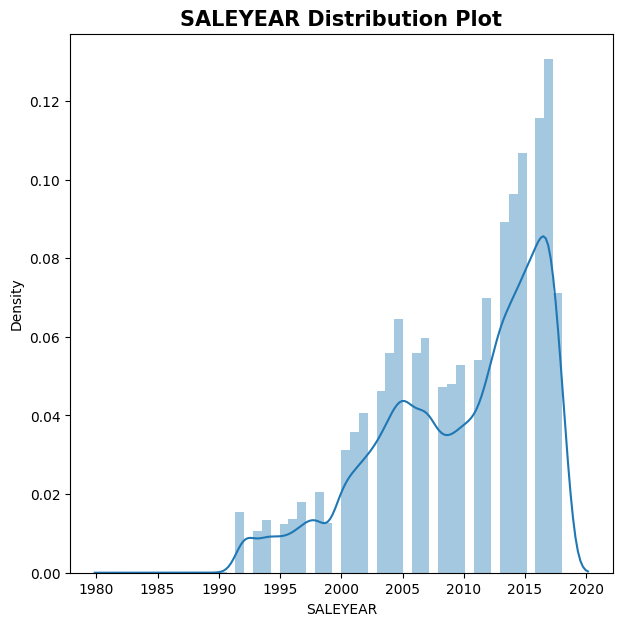

In [ ]:
feature = 'SALEYEAR'
plt.figure(figsize=(7, 7))
sns.distplot(df_model[feature])
plt.title('{} Distribution Plot'.format(feature), size=15, weight='bold')

Anomali pada distribusi fitur `SALEYEAR` dapat dianalisis sebagai berikut.

In [ ]:
bot_val = 2013

In [ ]:
lossnum = df_model[df_model[feature] < bot_val].count()[feature]
lossper = df_model[df_model[feature] < bot_val].count()[feature]/df.shape[0]*100
loss_col.append(feature + "_out")
loss_dat.append(lossper)
print('Jumlah outlier pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah outlier pada fitur SALEYEAR adalah  39949
Persentase outlier pada fitur SALEYEAR adalah  25.13%


Berdasarkan plot distribusi, pada harga penjualan properti terdapat *left-skewed distribution* atau terdapat skewness positif pada fitur `SALEYEAR`. Terdapat 0.01% outlier pada fitur `SALEYEAR` dimana tahun penjualan berada dibawah tahun 1990. Dikarenakan data penjualan dari tahun yang cukup lama tidak reliable untuk digunakan pada analisis dan model, maka data penjualan outlier akan dihapus dari dataset.

In [ ]:
df_model = df_model[(df_model[feature] >= bot_val)]

Text(0.5, 0, 'Range Selected SALEYEAR')

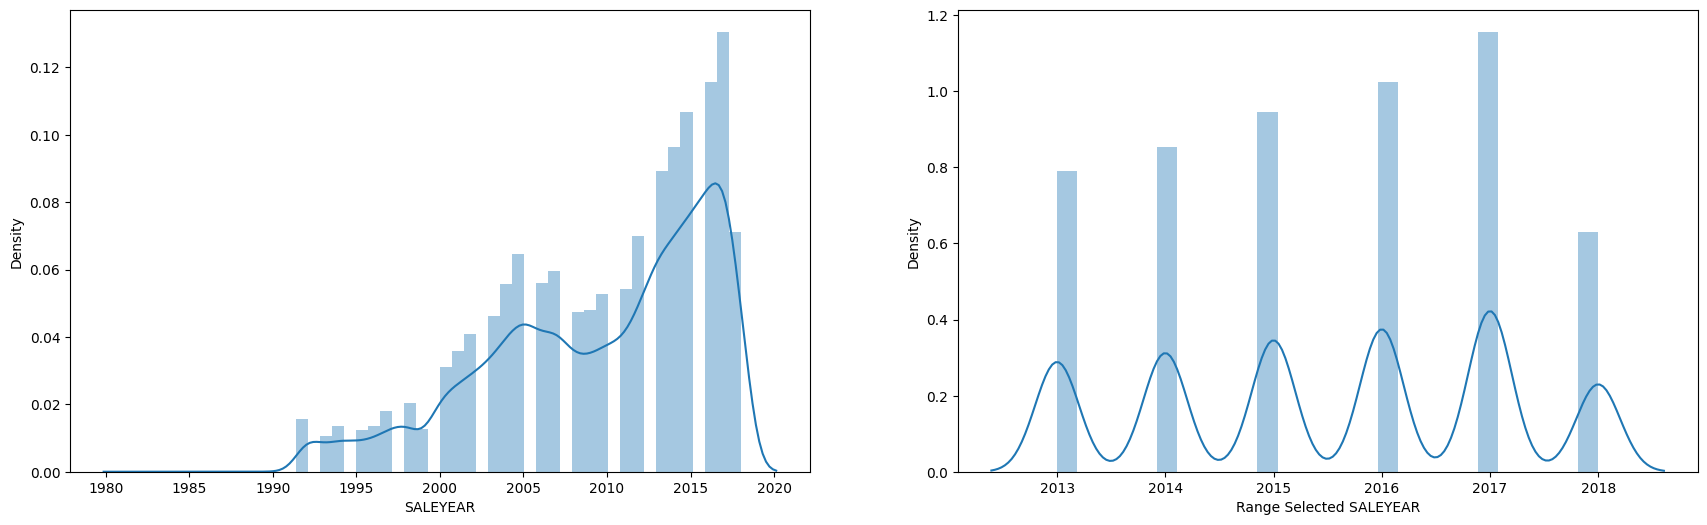

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df[feature], ax=axes[0])
sns.distplot(df_model[feature], ax=axes[1])
axes[0].set_xlabel(feature)
axes[1].set_xlabel('Range Selected {}'.format(feature))

### Feature: `ROOM`

Fitur `ROOM` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'ROOMS'
df_model[feature].describe()

count    31277.000000
mean         5.579435
std          2.361511
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         25.000000
Name: ROOMS, dtype: float64

Terdapat data anomali berupa jumlah ruangan sebanyak 0, sehingga data ini akan dibuang.

In [ ]:
lossnum = df_model[df_model[feature] == 0].count()[feature]
lossper = df_model[df_model[feature] == 0].count()[feature]/df.count()[feature]*100
loss_col.append(feature+"_0")
loss_dat.append(lossper)

print('Jumlah nilai 0 pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah nilai 0 pada fitur ROOMS adalah  10
Persentase outlier pada fitur ROOMS adalah  0.01%


In [ ]:
df_model = df_model.drop(df_model[df_model[feature] == 0].index, axis=0)

### Feature: `AC`

Fitur `AC` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'AC'
df_model[feature].describe()

count     31267
unique        3
top           Y
freq      27080
Name: AC, dtype: object

Berikut merupakan plot distribusi pada fitur `AC`. 

<AxesSubplot:xlabel='AC', ylabel='count'>

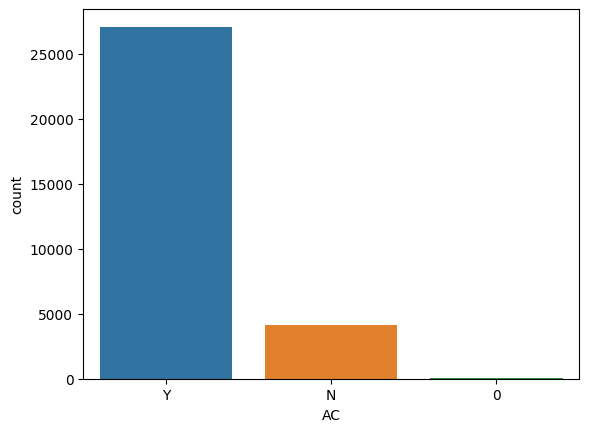

In [ ]:
sns.countplot(x=df_model[feature])

Dikarenakan terdapat nilai 0 pada feature `AC` yang tidak termasuk kedalam nilai yang dituju, maka row yang mengandung nilai ini akan dibuang.

In [ ]:
lossnum = df_model[df_model[feature] == '0'].count()[feature]
lossper = df_model[df_model[feature] == '0'].count()[feature]/df.count()[feature]*100
loss_col.append(feature+"_0")
loss_dat.append(lossper)

print('Jumlah nilai 0 pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah nilai 0 pada fitur AC adalah  21
Persentase outlier pada fitur AC adalah  0.01%


In [ ]:
df_model = df_model.drop(df_model[df_model[feature] == '0'].index, axis=0)

### Feature: `FIREPLACES`

Fitur `FIREPLACES` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'FIREPLACES'
df_model[feature].describe()

count    31246.000000
mean         0.398355
std          7.786380
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1017.000000
Name: FIREPLACES, dtype: float64

Berikut merupakan plot distribusi pada fitur `FIREPLACES`. 

Text(0.5, 1.0, 'FIREPLACES Distribution Plot')

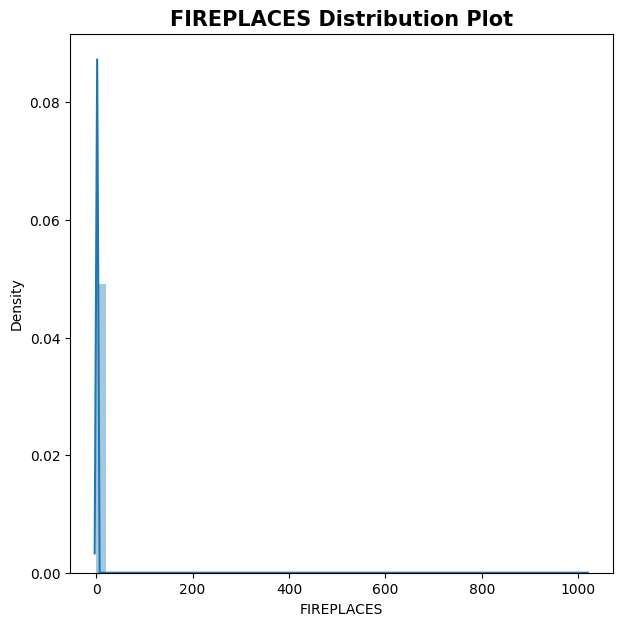

In [ ]:
plt.figure(figsize=(7, 7))
sns.distplot(df_model[feature])
plt.title('{} Distribution Plot'.format(feature), size=15, weight='bold')

Anomali pada distribusi fitur `FIREPLACES` dapat dianalisis sebagai berikut.

In [ ]:
df[df['FIREPLACES']>10]['FIREPLACES'].sort_values()

6999          11
21665         11
37034         11
683           12
20593         12
22341         12
2556          13
22103         13
31676         13
134069       200
115370       922
146813      1017
111896      1601
123974      4068
134928    293920
Name: FIREPLACES, dtype: int64

In [ ]:
up_val = 13

In [ ]:
lossnum = df_model[df_model[feature] > up_val].count()[feature]
lossper = df_model[df_model[feature] > up_val].count()[feature]/df.count()[feature]*100
loss_col.append(feature + "_out")
loss_dat.append(lossper)
print('Jumlah outlier pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah outlier pada fitur FIREPLACES adalah  2
Persentase outlier pada fitur FIREPLACES adalah  0.00%


Berdasarkan plot distribusi, pada harga penjualan properti terdapat *right-skewed distribution* atau terdapat skewness positif pada fitur `FIREPLACES`. Terdapat 0.69% outlier pada fitur `FIREPLACES` dimana jumlah pemanas api diatas 13. Dikarenakan nilai outlier tidak logis sebagai jumlah perapian, maka data dapat dihilangkan. Namun, hal ini dapat menjadi limitasi dari model yang dibangun.

In [ ]:
df_model = df_model[(df_model[feature] <= up_val)]

Text(0.5, 0, 'Range Selected FIREPLACES')

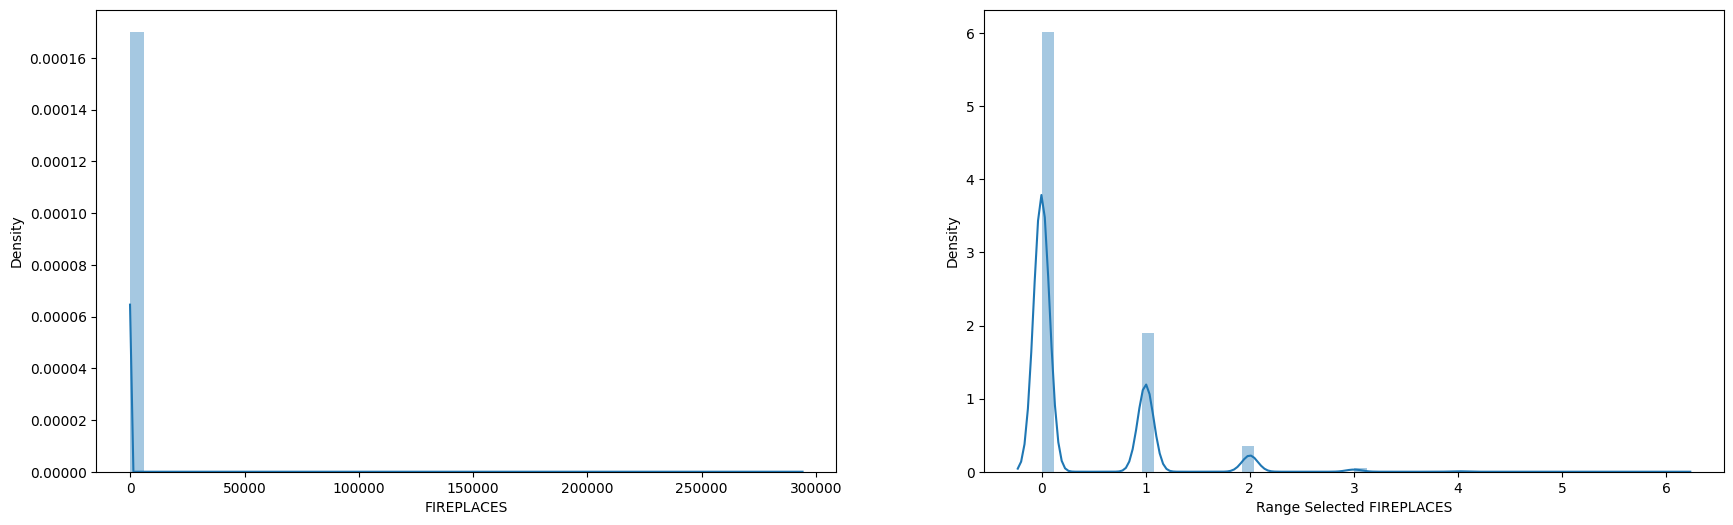

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df[feature], ax=axes[0])
sns.distplot(df_model[feature], ax=axes[1])
axes[0].set_xlabel(feature)
axes[1].set_xlabel('Range Selected {}'.format(feature))

Dari hasil data cleaning yang dilakukan pada feature `FIREPLACES`, didapatkan rentang data jumlah perapian pada properti diantara 0 - 13.

### Feature: `ASSESMENT_SUBNBHD`

Pengertian dari feature `ASSESMENT_SUBNBHD` merupakan subnomor dari perumahan. Dikarenakan tidak semua daerah memiliki subnomor maka feature ini dianggap tidak reliable dan dapat dihapus dari analisis.

In [ ]:
df_model.drop('ASSESSMENT_SUBNBHD',axis=1,inplace=True)

### FEATURE: `X`, `Y`

Data pada feature `X` dan `Y` sudah terwakili dari data pada feature `Latitude` dan `Longitude`. Maka dari itu kedua feature ini dapat dihapus dari analisis dan model.

In [ ]:
df_model.drop('X',axis=1,inplace=True)
df_model.drop('Y',axis=1,inplace=True)

### FEATURE: `QUADRANT`

Terdapat beberapa data hilang pada feature `Quadarant`. Data yang hilang akan diganti dengan data dari `FULLADDRESS`.

In [ ]:
def change_quad(x):
    if pd.isnull(x['QUADRANT']) == True:
        return x['FULLADDRESS'][-2:]
    else:
        return x['QUADRANT']
    
df_model['QUADRANT'] = df_model[['FULLADDRESS', 'QUADRANT']].apply(change_quad, axis = 1)

### FEATURE: `GIS_LAST_MOD_DTTM`, `CITY`, `STATE`, `FULLADDRESS`, `NATIONALGRID`, `CENSUSTRACK`, `CENSUSBLOCK`

Fitur-fitur tersebut tidak terlalu berguna dalam analisis dan model dikarenakan jumlah data unik yang hanya 1 ataupun terlalu banyak data unik yang mewakili setiap data, sehingga akan dihapus dari dataset.

In [ ]:
feature = ['GIS_LAST_MOD_DTTM', 'CITY', 'STATE', 'FULLADDRESS', 'NATIONALGRID', 'CENSUS_TRACT', 'CENSUS_BLOCK']

In [ ]:
for i in feature:
    df_model.drop(i, axis=1, inplace= True)

### Feature: `SOURCE`

Pada feature `SOURCE`, properti dibagi menjadi residensial dan kondominium. Kedua jenis properti tersebut memiliki susuna feature yang berbeda, maka dari itu dataset akan dibagi menjadi dua berdasarkan jenis properti pada feature `SOURCE`.

In [ ]:
df_res = df_model[df_model['SOURCE']== 'Residential']
df_con = df_model[df_model['SOURCE']== 'Condominium']

Akan dihapus feature yang tidak reliable pada setiap dataset sebagai berikut.

<AxesSubplot:>

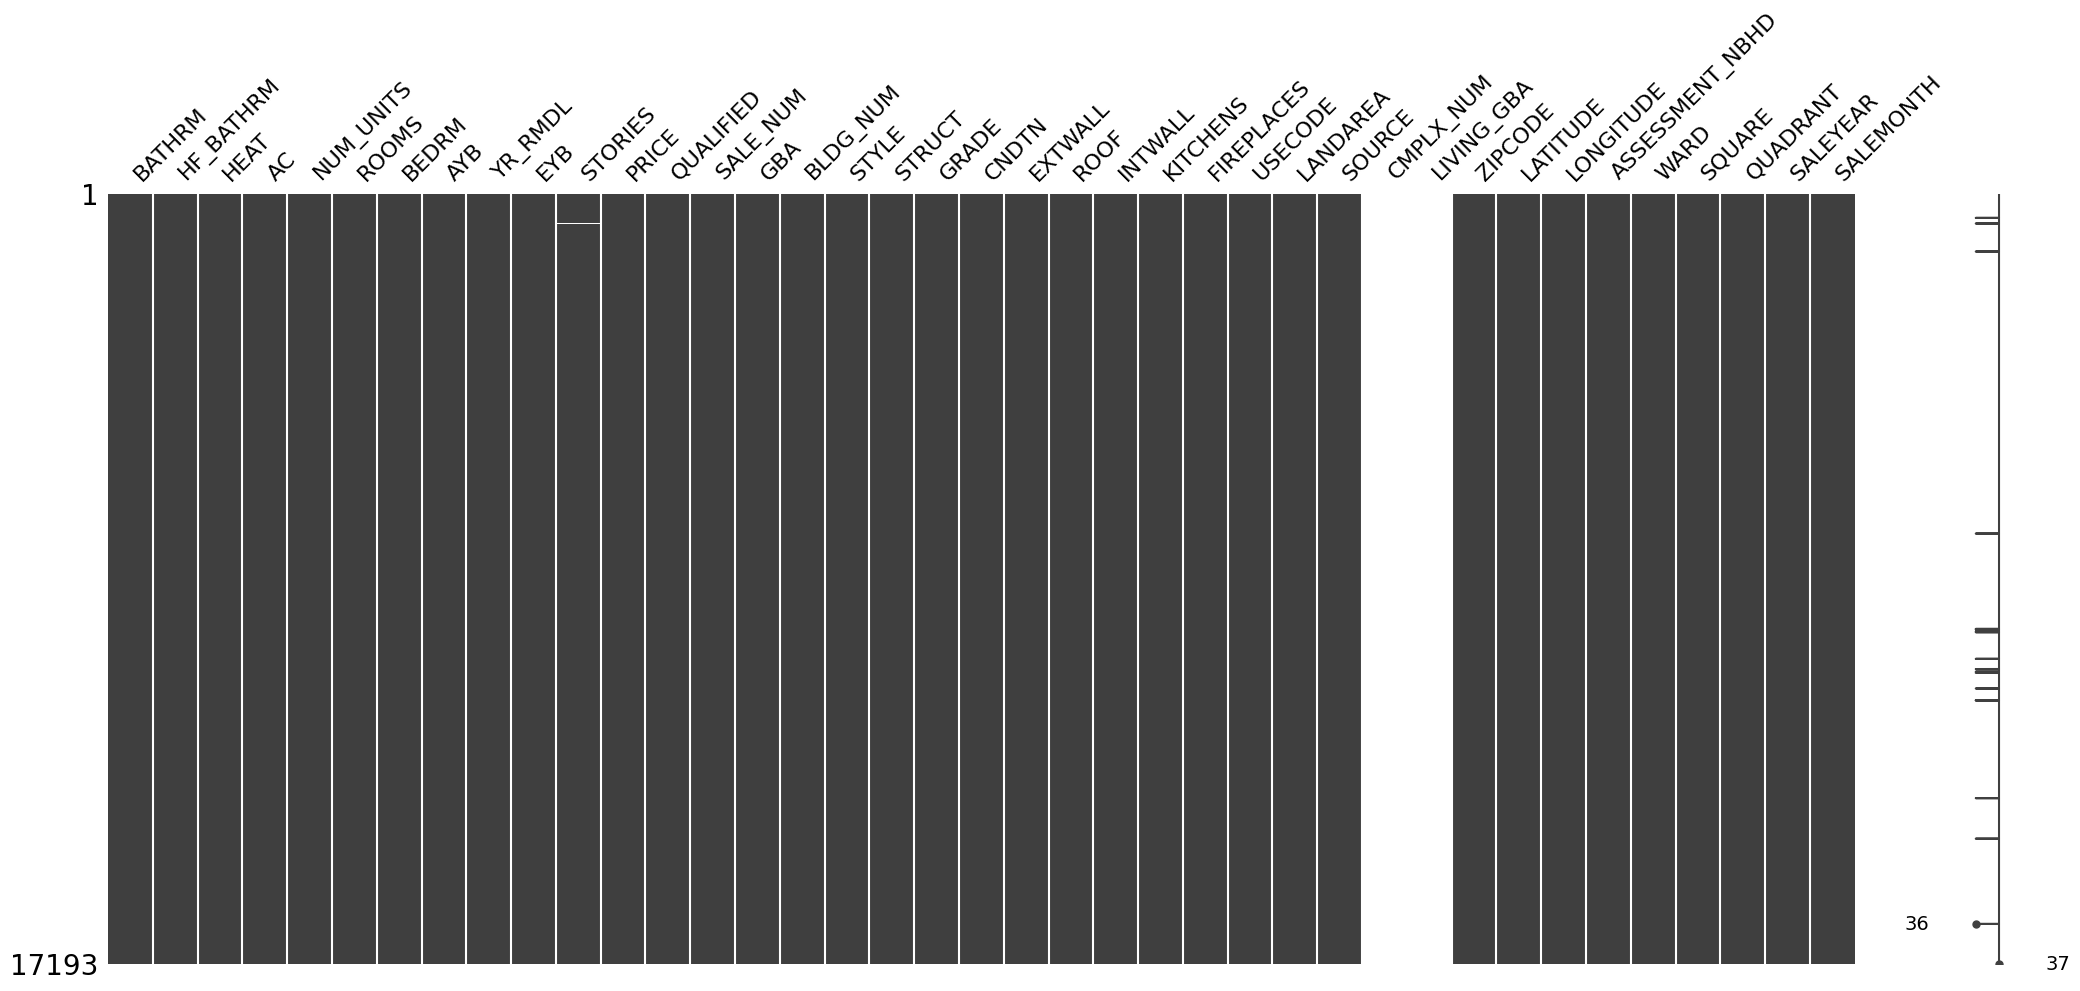

In [ ]:
#Dataset Residential
missingno.matrix(df_res)

In [ ]:
df_res.drop(['CMPLX_NUM', 'LIVING_GBA'], axis=1, inplace= True)

<AxesSubplot:>

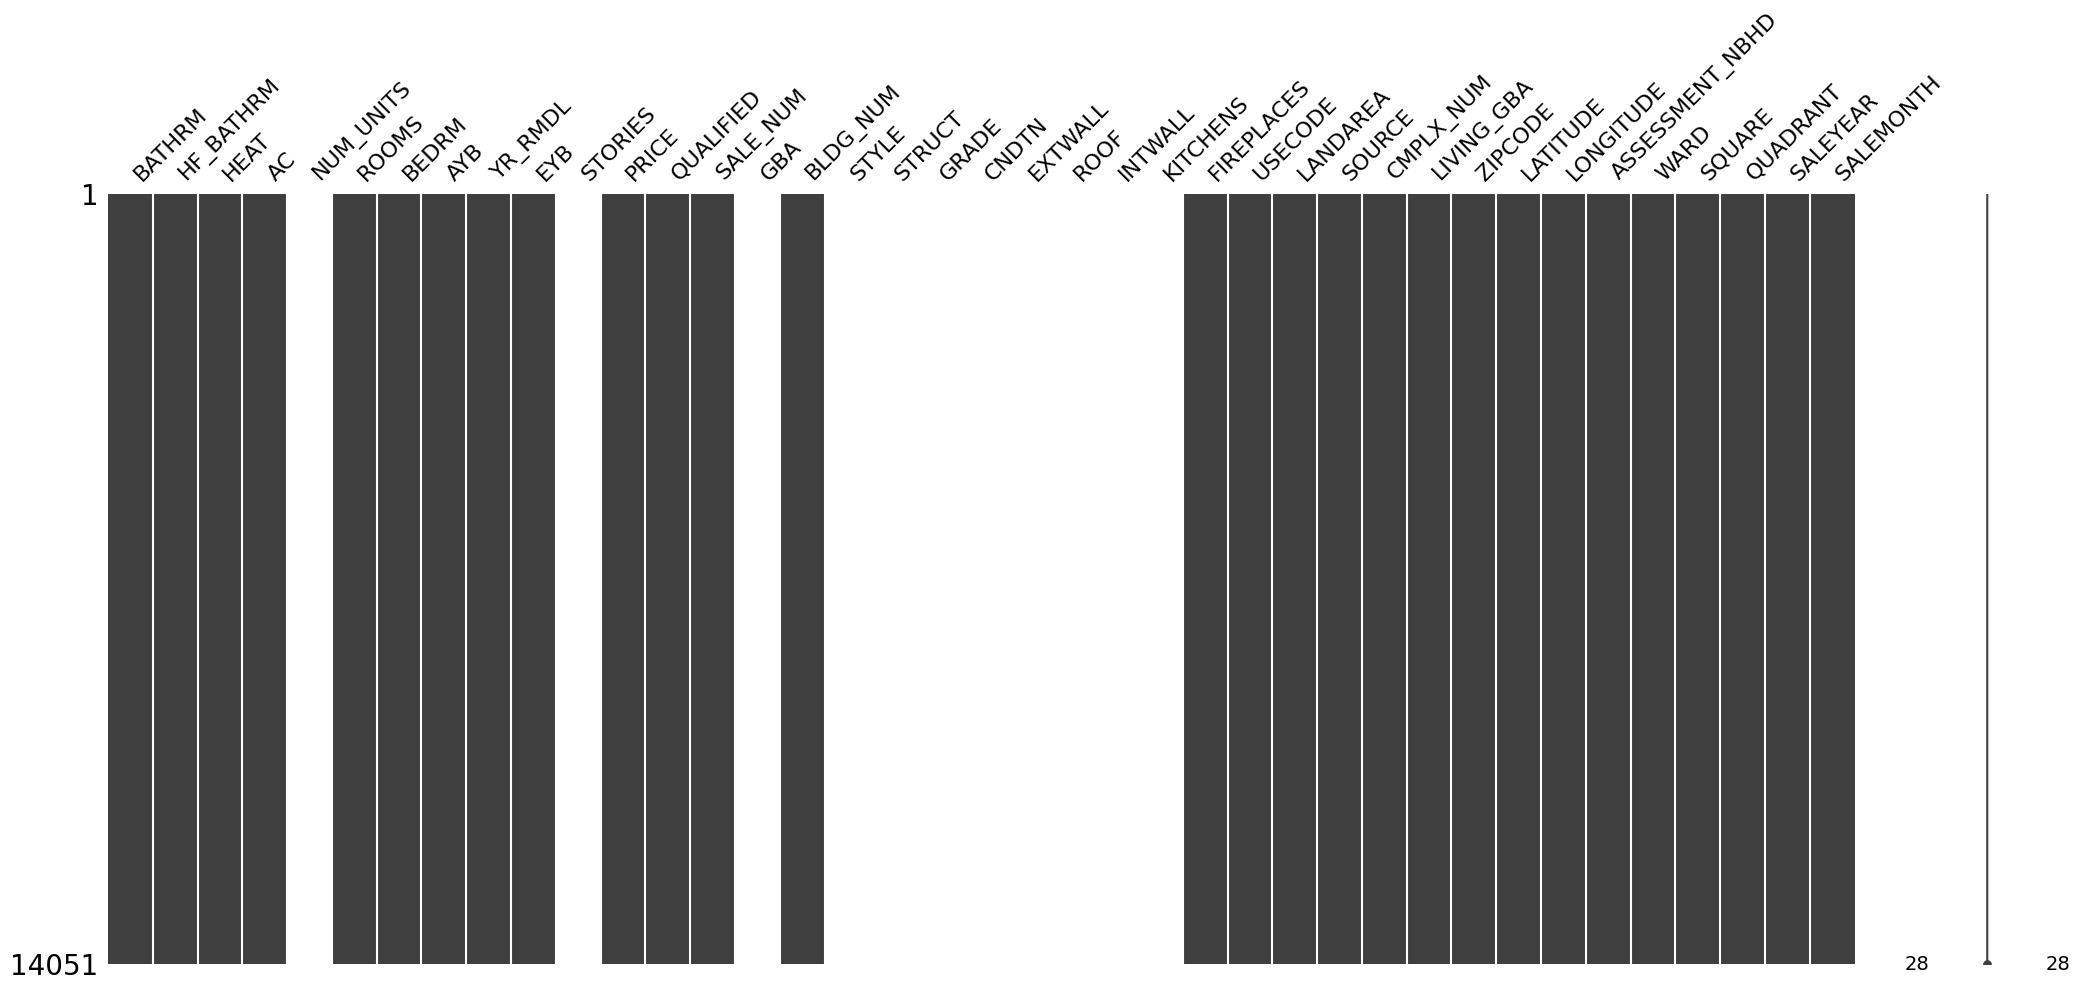

In [ ]:
#Dataset Condominium
missingno.matrix(df_con)

In [ ]:
df_con.drop(['NUM_UNITS','STORIES','GBA','STYLE','STRUCT','GRADE','CNDTN','EXTWALL','ROOF','INTWALL','KITCHENS'], axis=1, inplace= True)

### Feature: `LANDAREA`

Fitur `LANDAREA` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'LANDAREA'
df_model[feature].describe()

count    31244.000000
mean      1695.001888
std       1863.786715
min          0.000000
25%        383.000000
50%       1165.500000
75%       2202.250000
max      34491.000000
Name: LANDAREA, dtype: float64

Berikut merupakan plot distribusi pada fitur `LANDAREA` untuk jenis properti `Residential`. 

Text(0.5, 1.0, 'LANDAREA Distribution Plot')

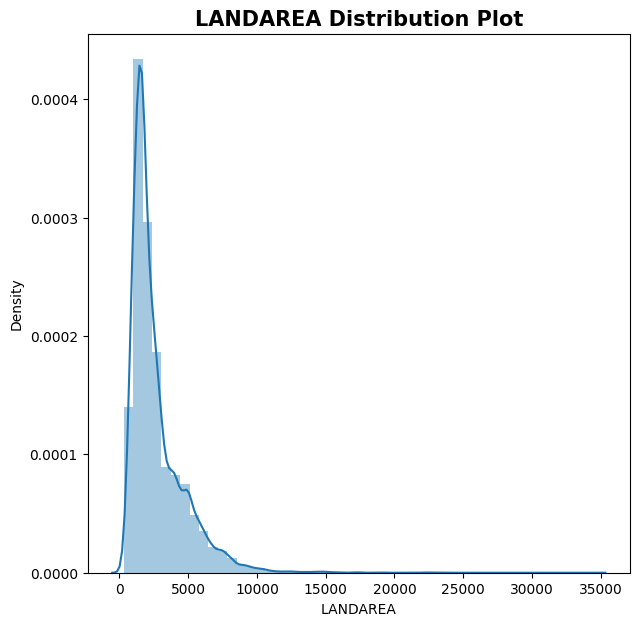

In [ ]:
plt.figure(figsize=(7, 7))
sns.distplot(df_res[feature])
plt.title('{} Distribution Plot'.format(feature), size=15, weight='bold')

In [ ]:
df_res[df["LANDAREA"] == 0]

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,SOURCE,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,WARD,SQUARE,QUADRANT,SALEYEAR,SALEMONTH


Dikarenakan terdapat nilai 0 pada feature `LANDAREA`, data ini tidak reliable untuk digunakan pada dataset, sehingga akan dihapus.

In [ ]:
lossnum = df_res[df_res[feature] == 0].count()[feature]
lossper = df_res[df_res[feature] == 0].count()[feature]/df.count()[feature]*100
loss_col.append(feature+"_0")
loss_dat.append(lossper)

print('Jumlah nilai 0 pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah nilai 0 pada fitur LANDAREA adalah  0
Persentase outlier pada fitur LANDAREA adalah  0.00%


In [ ]:
df_res = df_res.drop(df_res[df_res[feature] == 0].index, axis=0)

Berikut merupakan plot distribusi pada fitur `LANDAREA` untuk jenis properti `Condominium`. 

Text(0.5, 1.0, 'LANDAREA Distribution Plot')

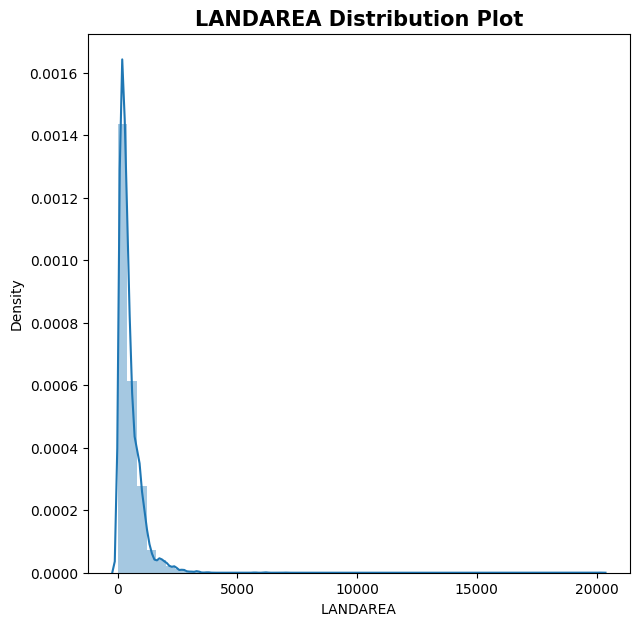

In [ ]:
plt.figure(figsize=(7, 7))
sns.distplot(df_con[feature])
plt.title('{} Distribution Plot'.format(feature), size=15, weight='bold')

Anomali pada distribusi fitur `LANDAREA` dapat dianalisis sebagai berikut.

In [ ]:
iqr, bot_val, up_val = fn_an(df_res[feature])
pr_an(df_res[feature])

IQR: 1913.0
limit_bawah: -1444.5
limit_atas: 6207.5


In [ ]:
lossnum = df_res[df_res[feature] > up_val].count()[feature]
lossper = df_res[df_res[feature] > up_val].count()[feature]/df.count()[feature]*100
loss_col.append(feature + "_out_res")
loss_dat.append(lossper)
print('Jumlah outlier pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah outlier pada fitur LANDAREA adalah  1036
Persentase outlier pada fitur LANDAREA adalah  0.65%


Berdasarkan plot distribusi, pada luas area terdapat *right-skewed distribution* atau terdapat skewness positif pada fitur `LANDAREA`. Terdapat 1.74% outlier pada fitur `LANDAREA` dimana luas area berada diatas 7015 ft2. Dikarenakan luas bangunan condominium pada outlier tidak cukup logis, sehingga data dianggap sebagai anomali dan dihapus dari dataset.

In [ ]:
df_con = df_con[(df_con[feature] <= up_val)]

Text(0.5, 0, 'Range Selected LANDAREA')

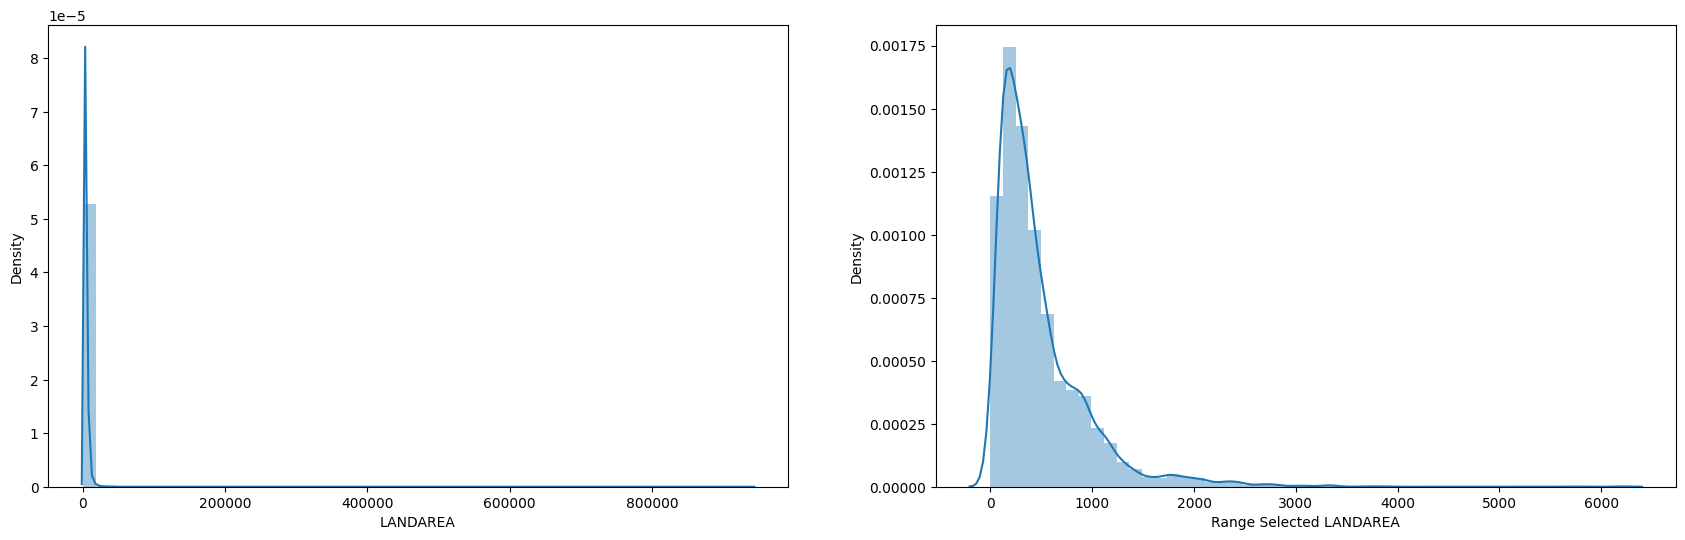

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df[feature], ax=axes[0])
sns.distplot(df_con[feature], ax=axes[1])
axes[0].set_xlabel(feature)
axes[1].set_xlabel('Range Selected {}'.format(feature))

Dari hasil data cleaning yang dilakukan pada feature `LANDAREA`, didapatkan rentang data luas area diantara 0 - 7015 m2

### Feature: `STORIES`

Fitur `STORIES` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'STORIES'
df_res[feature].describe()

count    17173.000000
mean         2.113213
std          6.308024
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        826.000000
Name: STORIES, dtype: float64

Berikut merupakan plot distribusi pada fitur `STORIES`. 

Text(0.5, 1.0, 'STORIES Distribution Plot')

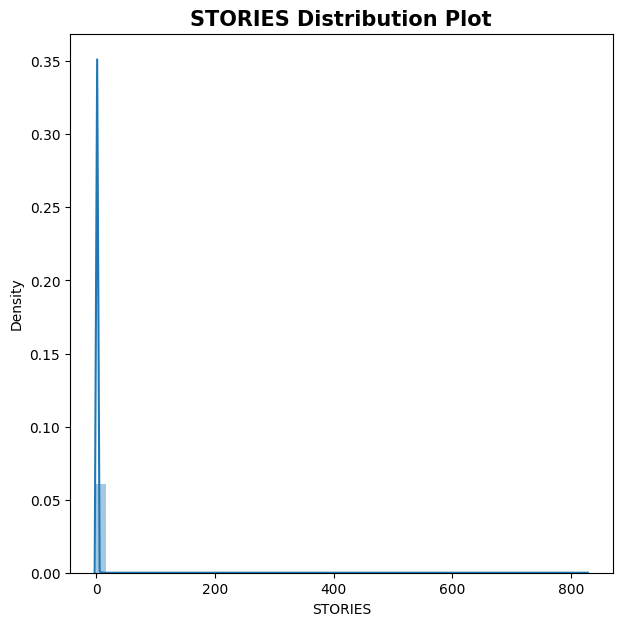

In [ ]:
# Plot distribusi fitur 'STORIES'
plt.figure(figsize=(7, 7))
sns.distplot(df_res[feature])
plt.title('{} Distribution Plot'.format(feature), size=15, weight='bold')

Anomali pada distribusi fitur `STORIES` dapat dianalisis sebagai berikut.

In [ ]:
df_res[df_res[feature] > 5][['ROOMS', 'STORIES']]

,ROOMS,STORIES
7546,6,826.00
44488,7,25.00
58360,7,9.00
58365,9,9.00
59217,7,6.00
59645,7,8.25
75663,6,9.00
79841,7,25.00
79853,7,25.00
85656,6,20.00


In [ ]:
up_val = 6

In [ ]:
lossnum = df_res[df_res[feature] > up_val].count()[feature]
lossper = df_res[df_res[feature] > up_val].count()[feature]/df.count()[feature]*100
loss_col.append(feature + "_out")
loss_dat.append(lossper)
print('Jumlah outlier pada fitur {} adalah '.format(feature), lossnum)
print('Persentase outlier pada fitur {} adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah outlier pada fitur STORIES adalah  11
Persentase outlier pada fitur STORIES adalah  0.01%


Berdasarkan plot distribusi, pada harga penjualan properti terdapat *right-skewed distribution* atau terdapat skewness positif pada fitur `STORIES`. Jika dibandingkan antara jumlah ruangan dan jumlah lantai, terdapat anomali pada jumlah lantai diatas 6. Maka dai itu, data akan dihapus dari analisis dan model.

In [ ]:
df_res = df_res[(df_res[feature] <= up_val)]

Text(0.5, 0, 'Range Selected STORIES')

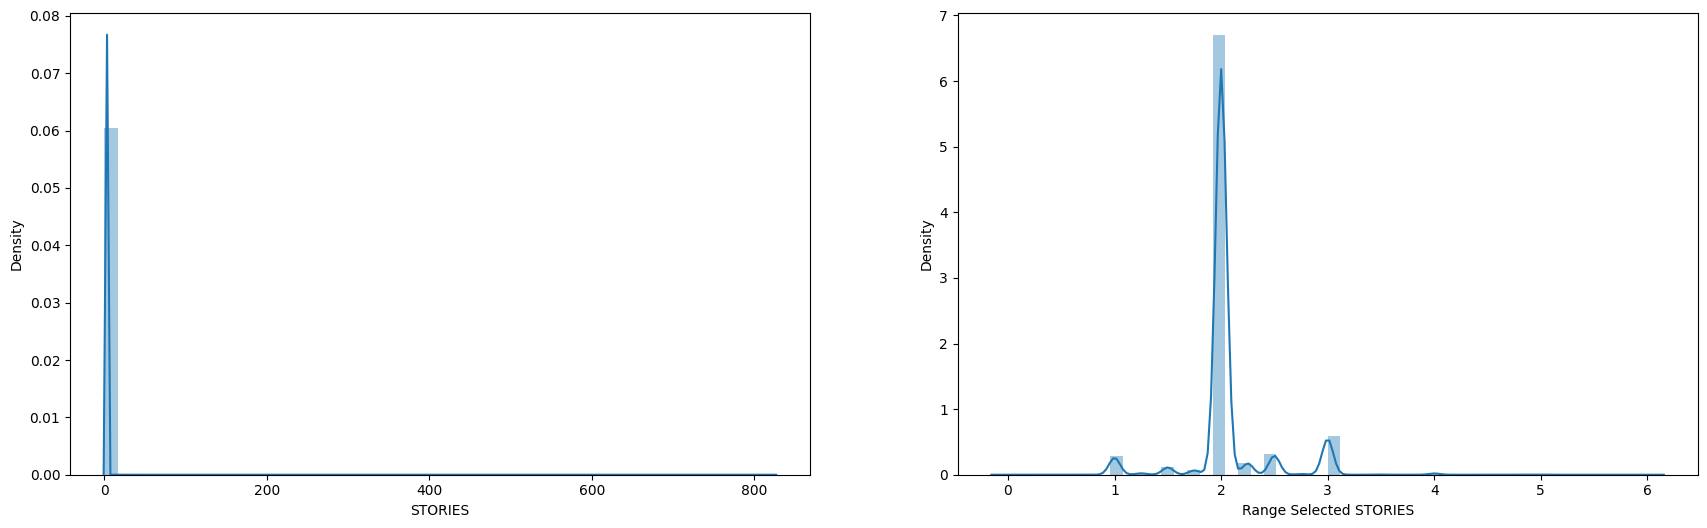

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df[feature], ax=axes[0])
sns.distplot(df_res[feature], ax=axes[1])
axes[0].set_xlabel(feature)
axes[1].set_xlabel('Range Selected {}'.format(feature))

Selain itu, terdapat beberapa data dengan jumlah lantai sebanyak 0 yang tidak cukup logis. Maka dari itu data akan dihapus.

In [ ]:
lossnum = df_res[df_res[feature] == 0].shape[0]
lossper = df_res[df_res[feature] == 0].shape[0]/df.shape[0]*100
loss_col.append(feature+"_null")
loss_dat.append(lossper)
print('Jumlah fitur {} dengan data hilang adalah '.format(feature), lossnum)
print('Persentase fitur {} dengan data hilang adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah fitur STORIES dengan data hilang adalah  2
Persentase fitur STORIES dengan data hilang adalah  0.00%


In [ ]:
df_res = df_res[(df_res[feature] != 0)]

Dari hasil data cleaning yang dilakukan pada feature `STORIES`, didapatkan rentang jumlah lantai pada properti residensial sebanyak 1-6

### Feature: `KITCHENS`

Fitur `KITCHENS` dapat dideskripsikan kembali sebagai berikut.

In [ ]:
feature = 'KITCHENS'
df_res[feature].describe()

count    17159.000000
mean         1.207821
std          0.569298
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: KITCHENS, dtype: float64

Berikut merupakan plot distribusi pada fitur `KITCHENS`. 

Text(0.5, 1.0, 'KITCHENS Distribution Plot')

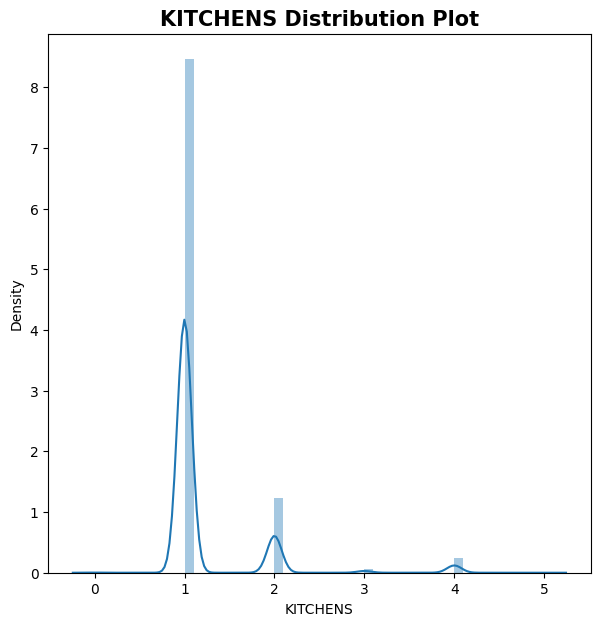

In [ ]:
plt.figure(figsize=(7, 7))
sns.distplot(df_model[feature])
plt.title('{} Distribution Plot'.format(feature), size=15, weight='bold')

Tidak terdapat anomali pada distribusi feature `KITCHENS` namun terdapat data hilang sehingga perlu dihapus.

In [ ]:
lossnum = df_res[df_res[feature].isnull()].shape[0]
lossper = df_res[df_res[feature].isnull()].shape[0]/df.shape[0]*100
loss_col.append(feature+"_null")
loss_dat.append(lossper)
print('Jumlah fitur {} dengan data hilang adalah '.format(feature), lossnum)
print('Persentase fitur {} dengan data hilang adalah '.format(feature), "{0:.2f}%".format(lossper))

Jumlah fitur KITCHENS dengan data hilang adalah  1
Persentase fitur KITCHENS dengan data hilang adalah  0.00%


In [ ]:
df_res.drop(df_res[df_res[feature].isnull()].index, inplace=True)

### **RESULT**

<AxesSubplot:>

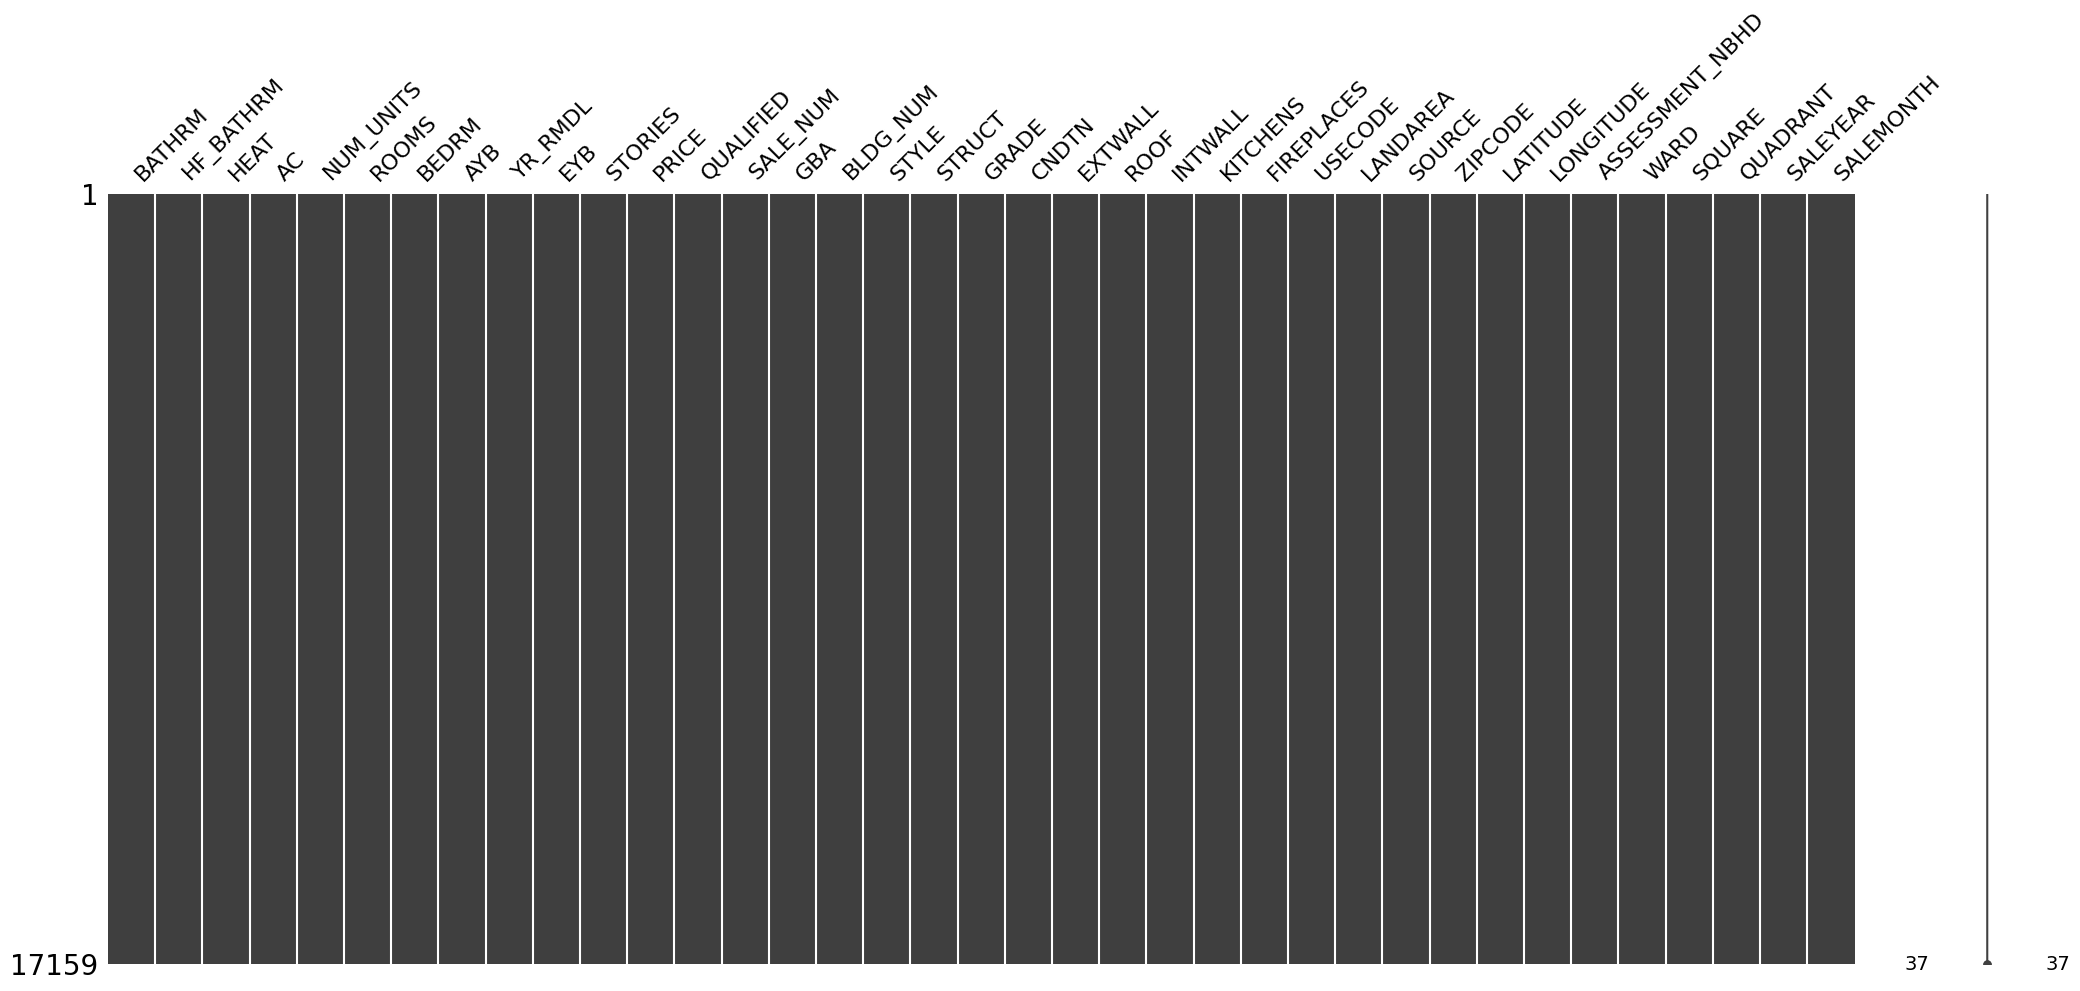

In [ ]:
missingno.matrix(df_res)

<AxesSubplot:>

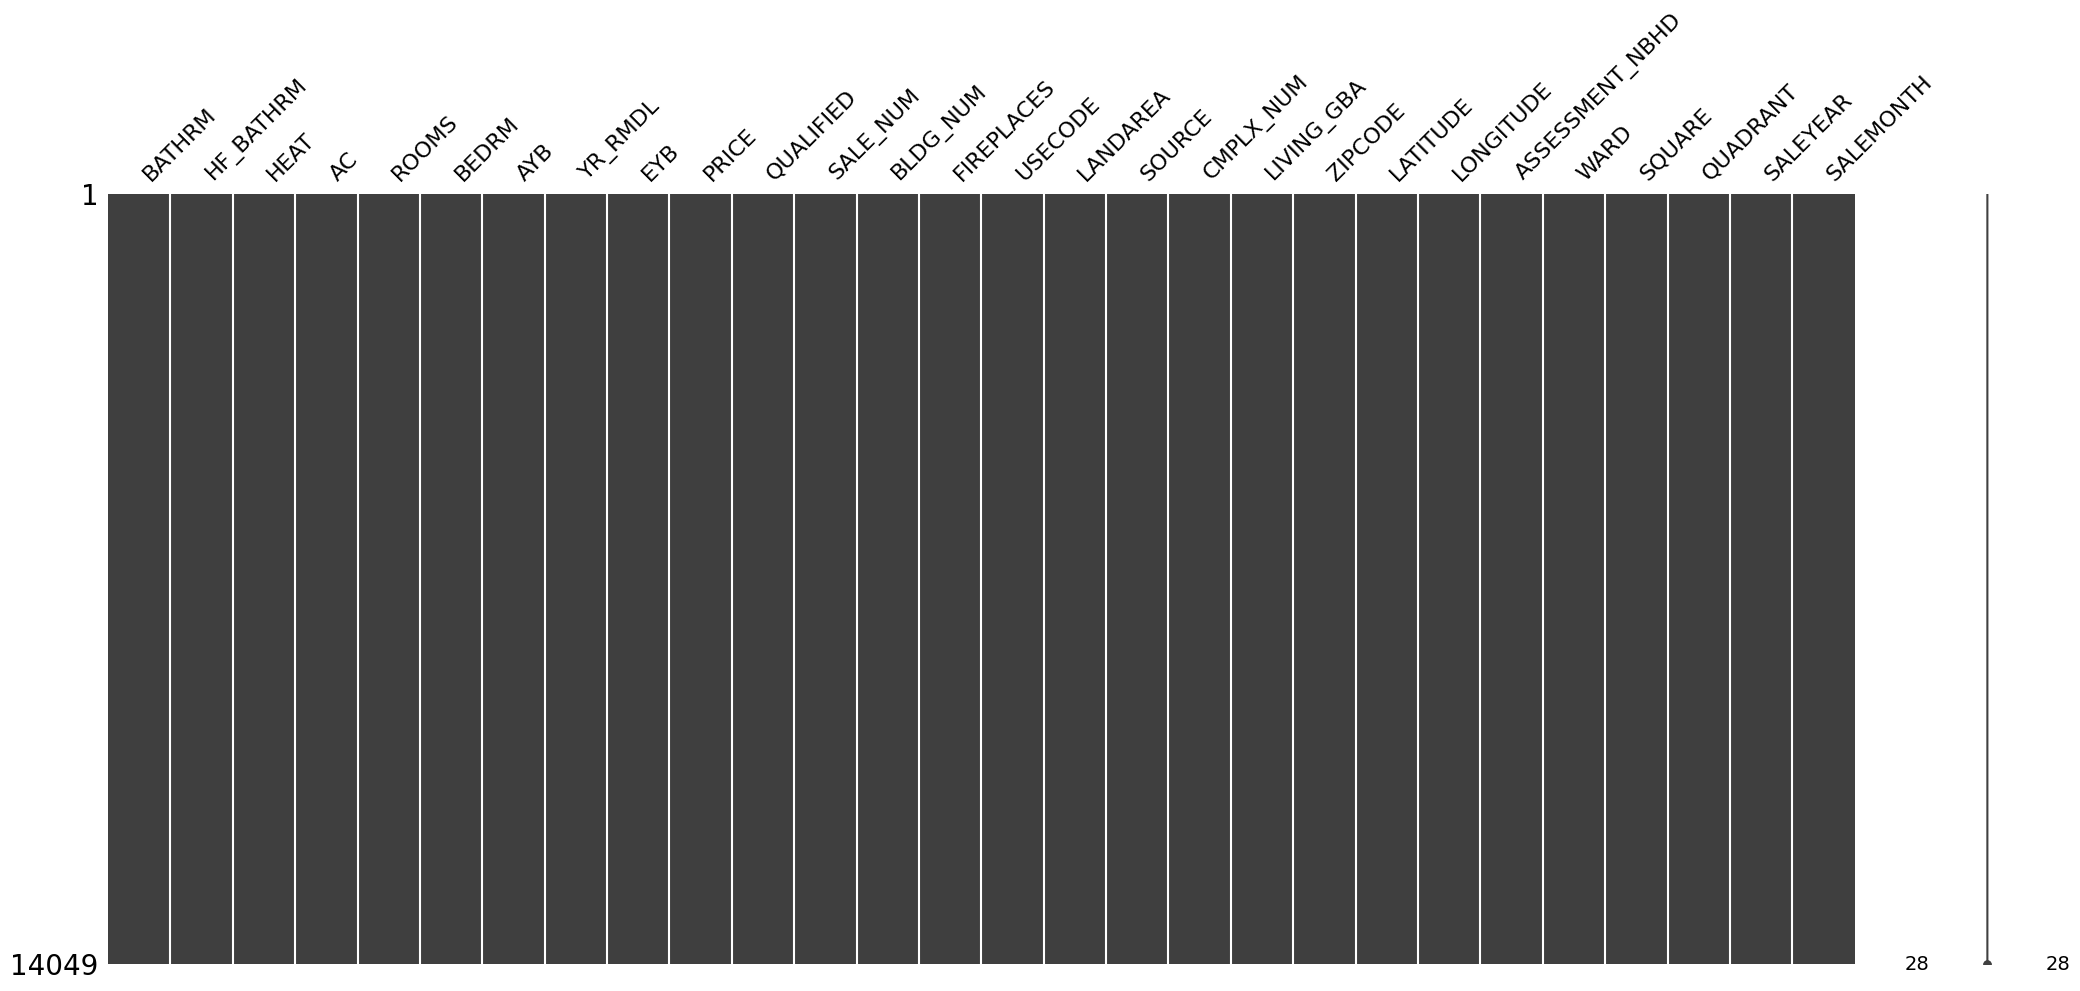

In [ ]:
missingno.matrix(df_con)

In [ ]:
result = pd.DataFrame(data= np.array(loss_dat).reshape(1,-1), columns=loss_col)
print("Data yang dihapus dari dataset adalah sebesar {0:.2f}%".format(result.sum(axis=1)[0]))

Data yang dihapus dari dataset adalah sebesar 81.01%


In [ ]:
result

,PRICE_null,PRICE_out,QUALIFIED_U,AYB_big,SALEYEAR_out,ROOMS_0,AC_0,FIREPLACES_out,LANDAREA_0,LANDAREA_out_res,STORIES_out,STORIES_null,KITCHENS_null
0,38.212221,3.557566,12.988418,0.434191,25.131954,0.006291,0.013211,0.001258,0.0,0.651749,0.010314,0.001258,0.000629


Terdapat limitasi dari model, diantaranya:
* `PRICE`:      $1 - $1.270.000
* `SALEYEAR`:   1990 - 2018
* `LANDAREA` (CONDOMINIUM):   0 - 7015 ft2
* `STORIES`(RESIDENTIAL):      1 - 6
* `FIREPLACES`: 0 - 13

In [ ]:
def unival (dataset):
    col=dataset.columns
    col_name=[]
    n_unique=[]
    unique_val=[]
    for i in col:
        col_name.append(i)
        n_unique.append(dataset[i].nunique())
        unique_val.append(dataset[i].unique())
    dfr=pd.DataFrame({'col_name':col_name,'n_unique':n_unique,'unique_val':unique_val})
    return dfr

unival(df_res)

,col_name,n_unique,unique_val
0,BATHRM,8,"[3, 4, 2, 1, 5, 6, 7, 0]"
1,HF_BATHRM,7,"[1, 2, 0, 3, 4, 5, 7]"
2,HEAT,14,"[Forced Air, Warm Cool, Hot Water Rad, Ht Pump..."
3,AC,2,"[Y, N]"
4,NUM_UNITS,6,"[2.0, 1.0, 3.0, 4.0, 0.0, 5.0]"
5,ROOMS,21,"[11, 8, 6, 7, 12, 5, 9, 4, 16, 10, 3, 13, 14, ..."
6,BEDRM,13,"[3, 4, 2, 5, 1, 8, 6, 0, 7, 9, 10, 12, 13]"
7,AYB,169,"[1900.0, 1907.0, 1979.0, 1939.0, 1885.0, 1904...."
8,YR_RMDL,2,"[1, 0]"
9,EYB,76,"[1984, 1964, 1990, 1985, 1967, 1957, 1969, 196..."


## **EXPORT DATA**

In [ ]:
df_model = pd.concat([df_res, df_con])

In [ ]:
df_model.to_csv("./data_cleaned/DF_FULL.csv")
df_res.to_csv("./data_cleaned/DF_Residential.csv")
df_con.to_csv("./data_cleaned/DF_Condominium.csv")